# ML Zoomcamp 
## Homework #6

Housing Prices Prediction

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from xgboost import XGBRegressor

print(pd.__version__)

2.0.3


In [2]:
df = pd.read_csv('./data/housing.csv')
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [3]:
df.shape

(20640, 10)

#### Preparation

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Next, use all the following columns:

'latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value',
'ocean_proximity'

Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [4]:
ocean_condition = df['ocean_proximity'].isin(['INLAND', '<1H OCEAN'])
df = df[ocean_condition]
cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']
df = df[cols]
df.reset_index(drop=True, inplace=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [5]:
df = df.fillna(0)
df['median_house_value'] = np.log1p(df['median_house_value'])
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973863,<1H OCEAN
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287653,<1H OCEAN
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419570,<1H OCEAN
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554967,<1H OCEAN
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287192,<1H OCEAN


In [47]:
df.ocean_proximity.value_counts()

ocean_proximity
COASTAL    9136
INLAND     6551
Name: count, dtype: int64

In [46]:
ocean_proximit_vals = {'<1H OCEAN': 'COASTAL', 'INLAND': 'INLAND'}
df['ocean_proximity'] = df['ocean_proximity'].map(ocean_proximit_vals)

In [48]:
X, y = df.drop('median_house_value', axis=1), df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((12549, 9), (1569, 9), (1569, 9), (12549,), (1569,), (1569,))

In [49]:
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')
X_test_dict = X_test.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train_encoded = dv.fit_transform(X_train_dict)
X_val_encoded = dv.transform(X_val_dict)
X_test_encoded = dv.transform(X_test_dict)

X_train_encoded.shape


(12549, 10)

In [51]:
dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=COASTAL',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

Q1)

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

-ocean_proximity
-total_rooms
-latitude
-population

A1) ocean_proximity

In [52]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train_encoded, y_train)

y_val_pred = dt.predict(X_val_encoded)


In [53]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.30]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



Q2) 
Train a random forest model with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on validation?

0.045

0.245

0.545

0.845

A2) 0.245 is the closest answer available to 0.23


In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train_encoded, y_train)

y_val_pred = rf.predict(X_val_encoded)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f'Validation RMSE: {rmse:.3f}')

Validation RMSE: 0.231


Q3) 
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

10

25

50

160

A3) 160


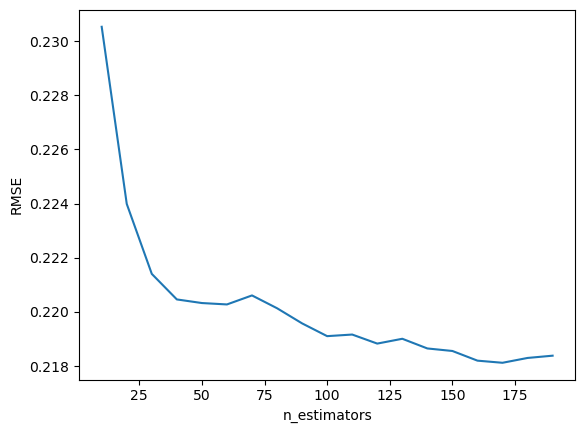

In [55]:
n_estimators = np.arange(10, 200, 10)
eval_errors = []

for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train_encoded, y_train)
    y_val_pred = rf.predict(X_val_encoded)
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    eval_errors.append(rmse)

plt.plot(n_estimators, eval_errors)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()


Q4) 
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
Fix the random seed: random_state=1
What's the best max_depth, using the mean RMSE?

10

15

20

25

A4)
At a max depth of 20, the mean RMSE is the lowest

[0.2314438842509224, 0.22121724594512615, 0.22070163205165325, 0.2207168312089529]


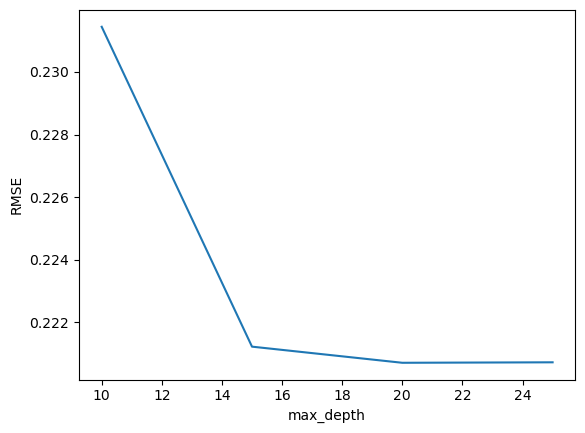

[160.          25.           0.21851108]


In [36]:
max_depths = [10, 15, 20, 25]
n_estimators = np.arange(10, 200, 10)

from itertools import product

eval_errors = []

for n, max_depth in product(n_estimators, max_depths):
    rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
    rf.fit(X_train_encoded, y_train)
    y_val_pred = rf.predict(X_val_encoded)
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    eval_errors.append([n, max_depth, rmse])

eval_errors = np.array(eval_errors)

mean_rmse = []
for max_depth in max_depths:
    mean_rmse.append(np.mean(eval_errors[eval_errors[:, 1] == max_depth][:, 2]))

print(mean_rmse)
plt.plot(max_depths, mean_rmse)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

best_params = eval_errors[np.argmin(eval_errors[:, 2])]
print(best_params)

Q5)

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
Get the feature importance information from this model
What's the most important feature (among these 4)?

total_rooms

median_income

total_bedrooms

longitude

A5)

median_income is the most important feature among the ones listed


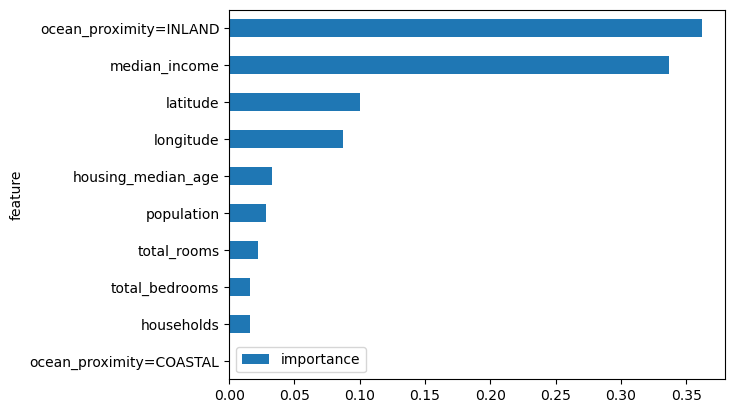

In [56]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train_encoded, y_train)

rf.feature_importances_

feature_importances = pd.DataFrame({'feature': dv.get_feature_names_out(), 'importance': rf.feature_importances_})
# feature_importances.sort_values('importance', ascending=False)

feature_importances.sort_values('importance', ascending=True).head(10).plot.barh(x='feature', y='importance')
plt.show()

Q6)

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost

Create DMatrix for train and validation

Create a watchlist

Train a model with these parameters for 100 rounds:
```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

0.3

0.1

Both give equal value

A6)

0.3 gives Validation RMSE: 0.213
0.1 gives Validation RMSE: 0.212 which is slightly better!


In [57]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train_encoded, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val_encoded, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test_encoded, label=y_test, feature_names=features)


In [61]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=5)

y_val_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f'Validation RMSE: {rmse:.3f}')



[0]	train-rmse:10.37475	val-rmse:10.36943
[5]	train-rmse:6.13403	val-rmse:6.12899
[10]	train-rmse:3.63224	val-rmse:3.62753
[15]	train-rmse:2.15842	val-rmse:2.15362
[20]	train-rmse:1.29323	val-rmse:1.28888
[25]	train-rmse:0.78992	val-rmse:0.78621
[30]	train-rmse:0.50292	val-rmse:0.50212
[35]	train-rmse:0.34671	val-rmse:0.34958
[40]	train-rmse:0.26752	val-rmse:0.27477
[45]	train-rmse:0.22980	val-rmse:0.24120
[50]	train-rmse:0.21289	val-rmse:0.22801
[55]	train-rmse:0.20514	val-rmse:0.22219
[60]	train-rmse:0.19957	val-rmse:0.21950
[65]	train-rmse:0.19429	val-rmse:0.21737
[70]	train-rmse:0.19112	val-rmse:0.21687
[75]	train-rmse:0.18753	val-rmse:0.21639
[80]	train-rmse:0.18462	val-rmse:0.21530
[85]	train-rmse:0.18159	val-rmse:0.21458
[90]	train-rmse:0.17892	val-rmse:0.21386
[95]	train-rmse:0.17645	val-rmse:0.21269
[99]	train-rmse:0.17437	val-rmse:0.21196
Validation RMSE: 0.212
